In [1]:
# forecast monthly births with random forest
from numpy import asarray
import pandas as pd
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.ensemble import RandomForestRegressor
from matplotlib import pyplot
import numpy as np

In [2]:
df = pd.read_csv('Dasatest_N.csv')
df['Month'] = pd.to_datetime(df.Month , format = '%d-%m-%Y')
data = df.drop(['Month'], axis=1)
data.index = df.Month
cols = data.columns
data.index.freq = 'MS'

In [3]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
# 	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols = list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
	# put it all together
	agg = concat(cols, axis=1)
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg.values

In [4]:
# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
	return data[:-n_test, :], data[-n_test:, :]

In [5]:
# fit an random forest model and make a one step prediction
def random_forest_forecast(train, testX):
	# transform list into array
	train = asarray(train)
	# split into input and output columns
	trainX, trainy = train[:, :-1], train[:, -1]
	# fit model
	model = RandomForestRegressor(n_estimators=1000)
	model.fit(trainX, trainy)
	# make a one-step prediction
	yhat = model.predict([testX])
	return yhat[0]

In [6]:
# walk-forward validation for univariate data
def walk_forward_validation(data, n_test):
	predictions = list()
	# split dataset
	train, test = train_test_split(data, n_test)
	# seed history with training dataset
	history = [x for x in train]
	# step over each time-step in the test set
	for i in range(len(test)):
		# split test row into input and output columns
		testX, testy = test[i, :-1], test[i, -1]
		# fit model on history and make a prediction
		yhat = random_forest_forecast(history, testX)
		# store forecast in list of predictions
		predictions.append(yhat)
		# add actual observation to history for the next loop
		history.append(test[i])
		# summarize progress
		print('>expected=%.3f, predicted=%.3f' % (testy, yhat))
	# estimate prediction error
	error = mean_absolute_percentage_error(test[:, -1], predictions)
	return error, test[:, -1], predictions

In [11]:
data_1 = df.iloc[:,3000]
values = np.array(data_1)

>expected=0.205, predicted=0.239
>expected=0.231, predicted=0.220
>expected=0.273, predicted=0.369
>expected=0.296, predicted=0.383
>expected=0.293, predicted=0.331
>expected=0.350, predicted=0.324
>expected=0.184, predicted=0.346
>expected=0.201, predicted=0.143
>expected=0.257, predicted=0.221
>expected=0.362, predicted=0.329
>expected=0.229, predicted=0.328
>expected=0.173, predicted=0.286
MAPE: 0.295


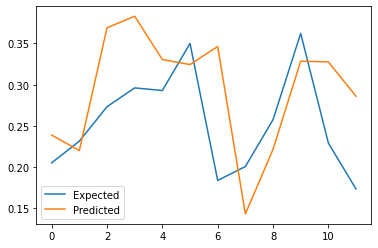

In [12]:
# transform the time series data into supervised learning
data = series_to_supervised(values, n_in=6)
# evaluate
mape, y, yhat = walk_forward_validation(data, 12)
print('MAPE: %.3f' % mape)
# plot expected vs predicted
pyplot.plot(y, label='Expected')
pyplot.plot(yhat, label='Predicted')
pyplot.legend()
pyplot.show()